# Digital homo- and heterodyne detection

In [1]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import os
from scipy.stats import kstest
from scipy.interpolate import interp1d
from random import choices
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
from scipy.special import factorial, eval_hermite, comb
import cvxpy as cp

from qutip import *

## Define operators

In [2]:
N=15

idc = qeye(N)
ida = qeye(2)
N_cav = tensor(num(N), ida)

a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2)) # note that this is not qutip's sigmam() definition

sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())

In [3]:
def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

def U_swap(theta):
    H = -1j*theta*(a.dag() * sm + a * sm.dag())
    return H.expm()

## Params

0.15707963267948966

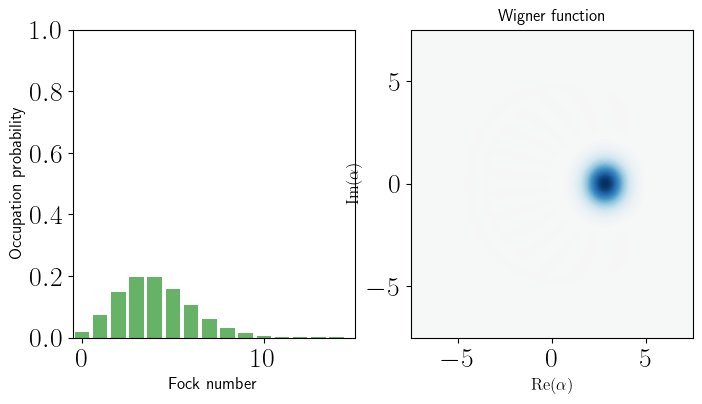

In [63]:
# number of qubit measurements per trajectory
Nmeas = 200

# number of trajectories
Ntrajs = 1000


theta = 0.1*np.pi/2

rotangl = 0 # 0 for axis=0 in np.trapz for W  # homodyne angle

# initialize state: cavity in coherent state, qubit in ground state 
alphain = 2
#initial_cavity = (fock(N, 0) + fock(N,4)).unit()
#initial_cavity = (coherent(N, alphain) + coherent(N,-alphain)).unit()
#initial_cavity= fock(N,1)
initial_cavity = coherent(N, alphain) 

psi0 = tensor(initial_cavity, basis(2,0))

plot_wigner_fock_distribution(initial_cavity);

theta

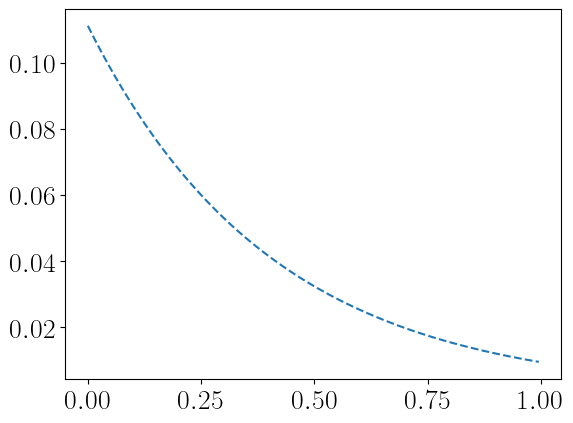

In [68]:
### Plot

nsteps = np.linspace(0,Nmeas-1,Nmeas)
weights=(theta/np.sqrt(2))*np.exp(-nsteps*(theta**2/2))
                                   
plt.plot(nsteps,weights,'--');

In [71]:
# histogram settings
k = 5 # histogram bin limit
Nbins = 55

# ideal distribution from Wigner marginal
x=np.linspace(-k,k,200)
dx = np.diff(x)[0]
W = wigner(initial_cavity, x, x)

marginal = np.trapz(W,x, axis=0)

# ideal cdf from marginal
cdf = np.cumsum(marginal)*dx
cdf_func = interp1d(x, cdf, fill_value="extrapolate")

#seed
#prng = np.random.RandomState(73885327)
#rnd = np.random.RandomState(61358529)

# System with no dissipation

In [72]:
# theta: effective interaction strength 
# correct_prob: probability of correct qubit measurement
def get_measurements(Ntrajs, theta, correct_prob):
    U_int = U_swap(theta)
    
    ### simulate tomography ###
    
    qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
    
    qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state
    measurements = []

    for j in range(Ntrajs):
        xrnd = np.random.rand(Nmeas)
        error = np.random.rand(Nmeas) 

        results = []
        psi = psi0

        for i in range(Nmeas):
            psi = qbrotmat * (U_int * psi)

            prob = expect(proj0,psi) # prob to be in gs
            if prob>xrnd[i]:
                # measured g
                results.append(-1 if error[i] <= correct_prob else 1) 
                #results.append(-1) correct result
                psi = (proj0 * psi).unit()
            else:
                results.append(1 if error[i] <= correct_prob else -1)
                #results.append(1) correct result
                # measured e
                psi = (proj1 * psi).unit()
                # go back to g
                psi = qbfeedback * psi

        measurements.append(np.sum(results*weights))

    # return measurement result and final vacuum population
    return measurements, psi.ptrace(0)[0,0].real   

### Test measurement

0.03598605033331692

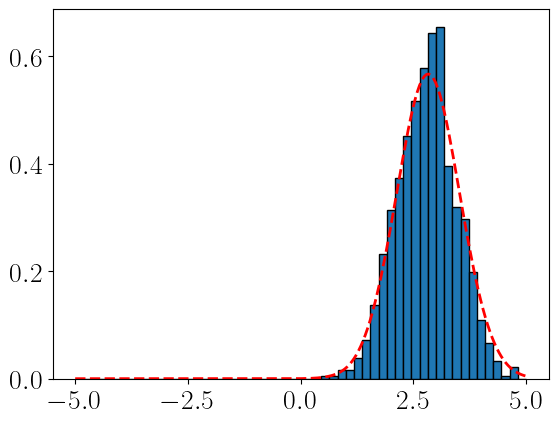

In [84]:
measurements, f_cavity_vac = get_measurements(Ntrajs, theta, 1)
    

plt.hist(measurements,Nbins,[-5,5], density=True, edgecolor='k')
plt.plot(x,marginal, 'r--',linewidth=2, label='$W$ marginal')

ks_stat = kstest(measurements, cdf_func)[0]
ks_stat

# Check qubit readout error

In [74]:
# compare histograms

# 50 % correct readout probability: completely random, should correspond to vacuum measurement
prob_50 = 0.5 
measurements_50, _ = get_measurements(Ntrajs, theta, prob_50)

# 80 % correct readout probability
prob_80 = 0.80
measurements_80, _ = get_measurements(Ntrajs, theta, prob_80)

# 90 % correct readout probability
prob_90 = 0.90
measurements_90, _ = get_measurements(Ntrajs, theta, prob_90)

# 95 % correct readout probability
prob_95 = 0.95
measurements_95, _ = get_measurements(Ntrajs, theta, prob_95)

# 100 % correct readout probability:
prob_100 = 1
measurements_100, _ = get_measurements(Ntrajs, theta, prob_100)

(0.5673237869479191, 0.04293353006810763)

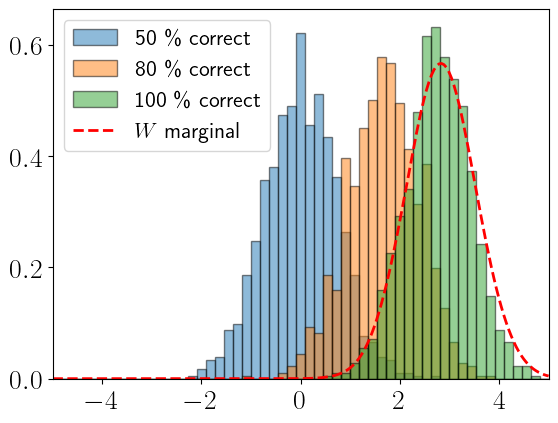

In [77]:
hist, bins, _ = plt.hist(measurements_50,Nbins,[-k,k], density=True, alpha=0.5, edgecolor='k', label='50 \% correct')
hist, bins, _ = plt.hist(measurements_80,Nbins,[-k,k], density=True, alpha=0.5, edgecolor='k', label='80 \% correct')
hist, bins, _ = plt.hist(measurements_100,Nbins,[-k,k], density=True, alpha=0.5, edgecolor='k', label='100 \% correct')

plt.plot(x,marginal, 'r--',linewidth=2, label='$W$ marginal')
plt.legend()
plt.xlim([-5,5])

ks_stat_80 = kstest(measurements_80, cdf_func)[0]
ks_stat_100 = kstest(measurements_100, cdf_func)[0]
ks_stat_80, ks_stat_100

## Loop over probabilities

In [129]:
%%time

# seeds for random number generation


# probability of correct readout
prob_list = np.linspace(0.80, 1.0, 11)

list_mean_ks_prob = []
list_var_ks_prob = []

nr_stats =  20 # number of times to run statistics

def get_stats_func():
    measurements, f_cavity_vac = get_measurements(Ntrajs, theta, prob)
    ks_stat = kstest(measurements, cdf_func)[0]
    return ks_stat

for idx, prob in enumerate(prob_list):
    print(prob)
    
    ks_stats = Parallel(n_jobs=nr_stats, backend="loky")(delayed(get_stats_func)() for i in range(nr_stats))
    mean_ks = np.mean(ks_stats)
    var_ks = np.var(ks_stats, ddof=1)    
    list_mean_ks_prob.append(mean_ks)
    list_var_ks_prob.append(var_ks)

0.8
0.8200000000000001
0.8400000000000001
0.86
0.88
0.9
0.92
0.9400000000000001
0.96
0.98
1.0
CPU times: user 1.61 s, sys: 280 ms, total: 1.89 s
Wall time: 25min 50s


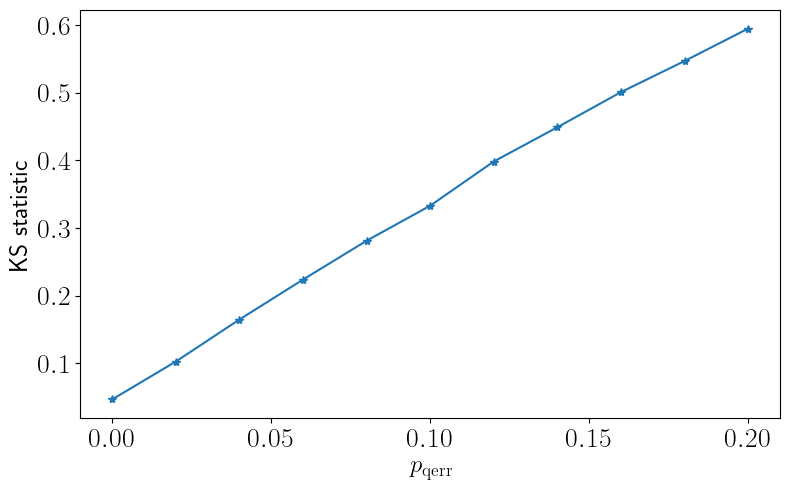

In [130]:
fig, ax = plt.subplots(figsize=(8,5))
error_prob = 1 - prob_list
ax.plot(error_prob, list_mean_ks_prob,'*-')
plt.ylabel(r'KS statistic')
plt.xlabel('$p_\mathrm{qerr}$')
#plt.xlim([-0.04,0.25])
plt.tight_layout()
#plt.savefig('KS_qubit_error_prob_wide.pdf')
#ax.invert_xaxis()

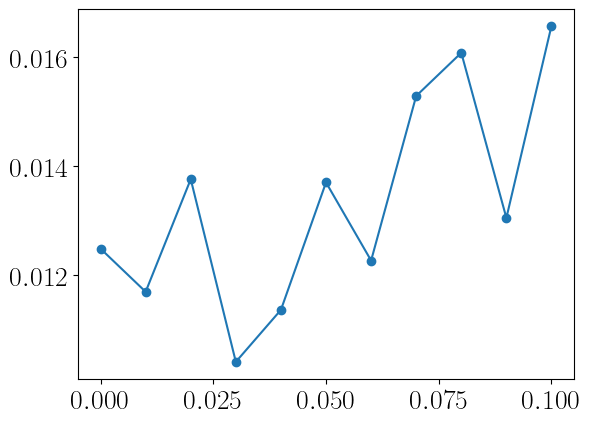

In [124]:
plt.plot(error_prob, np.sqrt(list_var_ks_prob), 'o-')

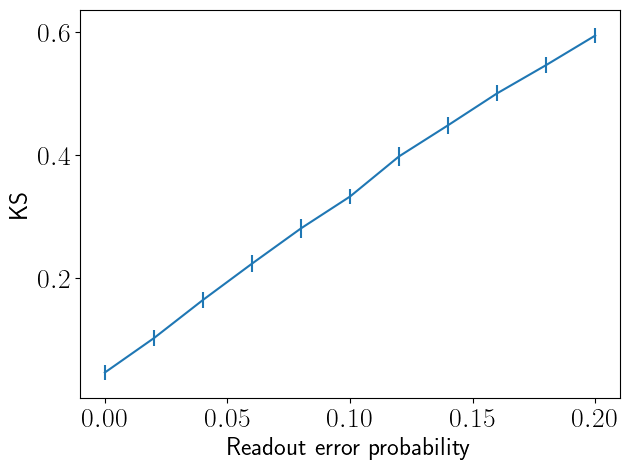

In [131]:
plt.errorbar(error_prob, list_mean_ks_prob, yerr=np.sqrt(list_var_ks_prob))
plt.ylabel('KS')
plt.xlabel('Readout error probability')
plt.tight_layout()
#plt.savefig('ks_vs_pqerr.pdf')

## Different number of trajectories Ntrajs

In [109]:
%%time

#seed
prng = np.random.RandomState(12775425)
rnd = np.random.RandomState(12115425)

rotangl = 0 # 0 for axis=0 in np.trapz for W # homodyne angle

# not parallellized
nr_stats = 20 # number of times to run statistics


ntrajs_list=[20, 50, 100, 300, 600, 1000, 1500]

list_mean_ks_ntrajs = []
list_var_ks_ntrajs = []

all_ks = np.zeros((len(ntrajs_list), nr_stats))

for idx, ntrajs in enumerate(ntrajs_list):
    ks_stats = []
    hists = []
    vacuum_pops = []
    print("ntrajs", ntrajs)
    
    for nr in range(nr_stats):
        measurements, f_cavity_vac = get_measurements(ntrajs, theta, 1)

        hist, bins = np.histogram(measurements, Nbins, [-k,k], density=True)

        ks_stat = kstest(measurements, cdf_func)[0]

        hists.append(hist)
        ks_stats.append(ks_stat)
        all_ks[idx,nr] = ks_stat 
                  
        vacuum_pops.append(f_cavity_vac)

    mean_ks = np.mean(ks_stats)
    var_ks = np.var(ks_stats)
    list_mean_ks_ntrajs.append(mean_ks)
    list_var_ks_ntrajs.append(var_ks)
    print(list_var_ks_ntrajs)

ntrajs 20
[0.002593356862527983]
ntrajs 50
[0.002593356862527983, 0.002096097015660638]
ntrajs 100
[0.002593356862527983, 0.002096097015660638, 0.0004690833805021808]
ntrajs 300
[0.002593356862527983, 0.002096097015660638, 0.0004690833805021808, 0.0002842991103202079]
ntrajs 600
[0.002593356862527983, 0.002096097015660638, 0.0004690833805021808, 0.0002842991103202079, 0.00013973642568633666]
ntrajs 1000
[0.002593356862527983, 0.002096097015660638, 0.0004690833805021808, 0.0002842991103202079, 0.00013973642568633666, 0.00011646873089449861]
ntrajs 1500
[0.002593356862527983, 0.002096097015660638, 0.0004690833805021808, 0.0002842991103202079, 0.00013973642568633666, 0.00011646873089449861, 6.259742374744387e-05]
CPU times: user 1h 37min 22s, sys: 4min 26s, total: 1h 41min 48s
Wall time: 1h 34min 57s


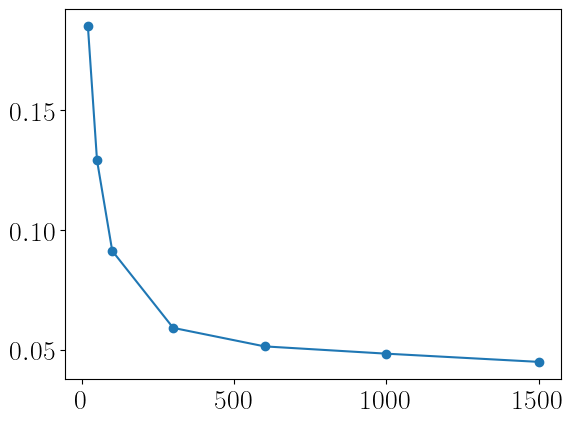

In [112]:
plt.plot(ntrajs_list, list_mean_ks_ntrajs, 'o-')

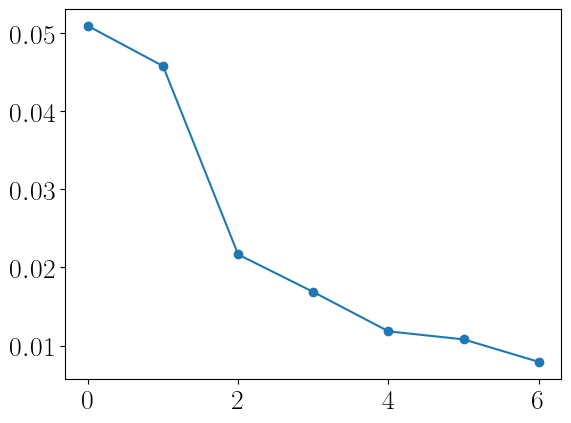

In [113]:
plt.plot(np.sqrt(list_var_ks_ntrajs), 'o-')

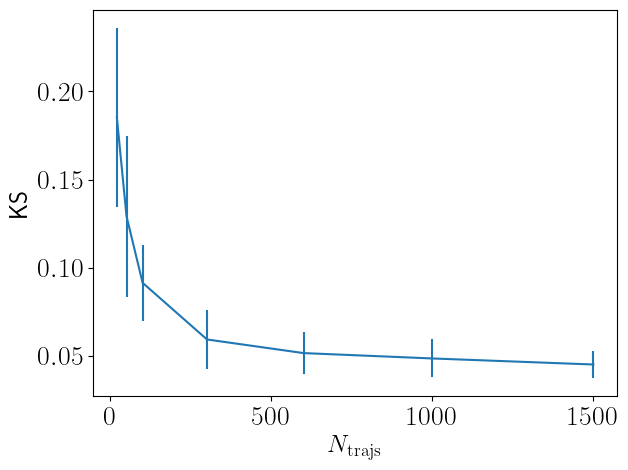

In [117]:
plt.errorbar(ntrajs_list, list_mean_ks_ntrajs, yerr = np.sqrt(list_var_ks_ntrajs))
plt.xlabel('$N_\mathrm{trajs}$')
plt.ylabel('KS')
plt.tight_layout()
#plt.savefig('ks_vs_ntrajs.pdf')